This notebook fetches data from dbnomics to predict Swedish Exports for the most recent quarter (explanatory variables are timelier).
Things to improve later: treatment of timeliness, pre-processing (scaling), add variables, ...

In [177]:
import pandas as pd
import numpy as np
from dbnomics import fetch_series, fetch_series_by_api_link

In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

### Fetch data

In [80]:
# Monthly CPI
cpi = fetch_series("OECD", "KEI", series_code="CPALTT01.SWE.GP.M")
cpi = cpi.query("period >= '2015'")
cpi = cpi[['period','value']]
cpi= cpi.rename(columns = {'value':'cpi'})

In [82]:
# Monthly price index, Energy
ep = fetch_series("IMF", "PCPS", series_code="M.W00.PNRG.IX")
ep = ep.query("period >= '2015'")
ep = ep[['period','value']]
ep = ep.rename(columns = {'value':'energy_prices'})

In [83]:
ep.head()

,period,energy_prices
276,2015-01-01,122.036324
277,2015-02-01,133.647404
278,2015-03-01,128.307725
279,2015-04-01,130.528800
280,2015-05-01,137.483494


In [84]:
# Monthly price index, Metals
mp = fetch_series("IMF", "PCPS", series_code="M.W00.PALLMETA.IX")
mp = mp.query("period >= '2015'")
mp = mp[['period','value']]
mp = mp.rename(columns = {'value':'metal_prices'})

In [86]:
# Monthly price index, Agriculture
ap = fetch_series("IMF", "PCPS", series_code="M.W00.PRAWM.IX")
ap = ap.query("period >= '2015'")
ap = ap[['period','value']]
ap = ap.rename(columns = {'value':'agri_prices'})

In [123]:
# Quarterly GDP 
gdp = fetch_series("OECD", "MEI", series_code="SWE.NAEXCP01.STSA.Q")
gdp = gdp.query("period >= '2015'")
gdp = gdp[['period','value']]
gdp = gdp.rename(columns = {'value':'gdp'})

In [88]:
# Quarterly Exports 
exports = fetch_series("OECD", "MEI", series_code="SWE.NAEXCP06.STSA.Q")
exports = exports.query("period >= '2015'")
exports = exports[['period','value']]
exports = exports.rename(columns = {'value':'exports'})

In [89]:
# Monthly confidence  
confidence = fetch_series("OECD", "KEI", series_code="BSCICP02.SWE.ST.M")
confidence = confidence.query("period >= '2015'")
confidence = confidence[['period','value']]
confidence = confidence.rename(columns = {'value':'confidence'})

In [90]:
# Exchange rates
excr = fetch_series("OECD", "KEI", series_code="CCUSMA02.SWE.ST.M")
excr = excr.query("period >= '2015'")
excr = excr[['period','value']]
excr = excr.rename(columns = {'value':'exch_rate'})

In [95]:
m = pd.merge(cpi, ep, on = 'period')
m = pd.merge(m, mp, on = 'period')
m = pd.merge(m, ap, on = 'period')
m = pd.merge(m, confidence, on = 'period')

In [100]:
m.head()

,period,cpi,energy_prices,metal_prices,agri_prices,confidence
0,2015-01-01,-1.050788,122.036324,110.950846,104.200238,-3.3
1,2015-02-01,0.701529,133.647404,107.747707,105.552220,-3.2
2,2015-03-01,0.083086,128.307725,104.520798,102.531777,-1.8
3,2015-04-01,-0.009579,130.528800,104.149816,104.192109,-7.2
4,2015-05-01,0.344872,137.483494,107.207184,106.129278,0.2


In [125]:
q = pd.merge(gdp, exports, on = 'period',  how = 'left')

In [126]:
# Move period defining quarter from the first to the last month 
q['period'] = q['period'] + pd.DateOffset(months=2)

In [127]:
q.head()

,period,gdp,exports
0,2015-03-01,1042.871,459.302
1,2015-06-01,1057.844,464.352
2,2015-09-01,1073.916,469.678
3,2015-12-01,1084.969,471.105
4,2016-03-01,1086.052,458.042


In [150]:
df = pd.merge(m,q, on = 'period', how = 'left')

In [151]:
df.head()

,period,cpi,energy_prices,metal_prices,agri_prices,confidence,gdp,exports
0,2015-01-01,-1.050788,122.036324,110.950846,104.200238,-3.3,NaN,NaN
1,2015-02-01,0.701529,133.647404,107.747707,105.552220,-3.2,NaN,NaN
2,2015-03-01,0.083086,128.307725,104.520798,102.531777,-1.8,1042.871,459.302
3,2015-04-01,-0.009579,130.528800,104.149816,104.192109,-7.2,NaN,NaN
4,2015-05-01,0.344872,137.483494,107.207184,106.129278,0.2,NaN,NaN


In [152]:
df['gdpm'] = df['gdp']/3
df['gdpm'] = df['gdpm'].fillna(method = 'bfill')

In [153]:
df['expm'] = df['exports']/3
df['expm'] = df['expm'].fillna(method = 'bfill')

In [154]:
df.tail(10)

,period,cpi,energy_prices,metal_prices,agri_prices,confidence,gdp,exports,gdpm,expm
87,2022-04-01,0.617009,300.533178,194.044295,133.321796,24.8,NaN,NaN,491.013000,252.039333
88,2022-05-01,1.049666,306.674979,178.515934,134.699574,27.2,NaN,NaN,491.013000,252.039333
89,2022-06-01,1.402329,328.123480,173.812350,130.495182,20.8,1473.039,756.118,491.013000,252.039333
90,2022-07-01,0.088961,343.809997,156.129551,119.614529,20.4,NaN,NaN,499.789000,264.245000
91,2022-08-01,1.758780,376.412083,158.734847,117.685200,19.0,NaN,NaN,499.789000,264.245000
92,2022-09-01,1.429290,330.149586,151.220233,110.620482,12.6,1499.367,792.735,499.789000,264.245000
93,2022-10-01,0.216591,259.858676,148.620228,104.825132,8.3,NaN,NaN,499.881333,271.001333
94,2022-11-01,1.012915,256.859739,154.517386,105.618315,9.5,NaN,NaN,499.881333,271.001333
95,2022-12-01,2.069961,258.501791,164.732037,107.851906,7.6,1499.644,813.004,499.881333,271.001333
96,2023-01-01,-1.126376,223.272585,175.412945,109.540121,4.6,NaN,NaN,NaN,NaN


In [155]:
df.drop(columns = ['gdp', 'exports'],  inplace = True)

In [162]:
df.rename(columns = {'gdpm': 'gdp', 'expm':'exports', 'period':'date'},  inplace = True)

In [163]:
df.head()

,date,cpi,energy_prices,metal_prices,agri_prices,confidence,gdp,exports
0,2015-01-01,-1.050788,122.036324,110.950846,104.200238,-3.3,347.623667,153.100667
1,2015-02-01,0.701529,133.647404,107.747707,105.552220,-3.2,347.623667,153.100667
2,2015-03-01,0.083086,128.307725,104.520798,102.531777,-1.8,347.623667,153.100667
3,2015-04-01,-0.009579,130.528800,104.149816,104.192109,-7.2,352.614667,154.784000
4,2015-05-01,0.344872,137.483494,107.207184,106.129278,0.2,352.614667,154.784000


In [213]:
data = df

### Train

In [263]:
# Train and test split

# Dates
train_start_date = "2015-01-01"
train_end_date = "2020-03-01"
test_start_date = "2020-04-01"
test_end_date = "2020-12-01"

# Split
train = data.loc[(data['date']>= train_start_date) & (data['date'] <= train_end_date), :].reset_index(drop = True)
test = data.loc[(data['date'] >= train_start_date) & (data['date'] <= test_end_date), :].reset_index(drop = True)
#test = data.loc[(data['date'] >= test_start_date) & (data['date'] <= test_end_date), :].reset_index(drop = True)

In [264]:
# Target variable
target_variable = 'exports' 

In [265]:
# Impute by forward filling
train_processed = train.fillna(method = 'ffill')

In [266]:
# Impute remaining missing observations by backward filling
train_processed = train_processed.fillna(method = 'bfill')

In [267]:
#continuous = train_processed.select_dtypes(include = [np.number]).columns

In [268]:
#train_processed[continuous] = StandardScaler().fit_transform(train_processed[continuous])

In [269]:
train_processed.head()

,date,cpi,energy_prices,metal_prices,agri_prices,confidence,gdp,exports
0,2015-01-01,-1.050788,122.036324,110.950846,104.200238,-3.3,347.623667,153.100667
1,2015-02-01,0.701529,133.647404,107.747707,105.552220,-3.2,347.623667,153.100667
2,2015-03-01,0.083086,128.307725,104.520798,102.531777,-1.8,347.623667,153.100667
3,2015-04-01,-0.009579,130.528800,104.149816,104.192109,-7.2,352.614667,154.784000
4,2015-05-01,0.344872,137.483494,107.207184,106.129278,0.2,352.614667,154.784000


In [270]:
# train 10 models to average outputs
models = []
for i in range(10):
    model = GradientBoostingRegressor(n_estimators = 100, 
                                      loss = "absolute_error", 
                                      max_depth = None, 
                                      min_samples_split = 2, 
                                      min_samples_leaf = 1)

    
    x = train_processed.drop(["date", target_variable], axis=1)
    y = train_processed[target_variable]
    
    model.fit(x, y)
    models.append(model)

### Evaluate performance

In [271]:
# Pre-process test data
test_processed = test.fillna(method = 'ffill')
test_processed = test_processed.fillna(method = 'bfill')
#test_processed[continuous] = StandardScaler().fit_transform(test_processed[continuous])

In [272]:
test_processed.head()

,date,cpi,energy_prices,metal_prices,agri_prices,confidence,gdp,exports
0,2015-01-01,-1.050788,122.036324,110.950846,104.200238,-3.3,347.623667,153.100667
1,2015-02-01,0.701529,133.647404,107.747707,105.552220,-3.2,347.623667,153.100667
2,2015-03-01,0.083086,128.307725,104.520798,102.531777,-1.8,347.623667,153.100667
3,2015-04-01,-0.009579,130.528800,104.149816,104.192109,-7.2,352.614667,154.784000
4,2015-05-01,0.344872,137.483494,107.207184,106.129278,0.2,352.614667,154.784000


In [273]:
y_true = test_processed[target_variable].values

In [274]:
y_true

array([153.10066667, 153.10066667, 153.10066667, 154.784     ,
       154.784     , 154.784     , 156.55933333, 156.55933333,
       156.55933333, 157.035     , 157.035     , 157.035     ,
       152.68066667, 152.68066667, 152.68066667, 151.351     ,
       151.351     , 151.351     , 156.406     , 156.406     ,
       156.406     , 165.17566667, 165.17566667, 165.17566667,
       163.92433333, 163.92433333, 163.92433333, 169.69133333,
       169.69133333, 169.69133333, 167.09433333, 167.09433333,
       167.09433333, 173.427     , 173.427     , 173.427     ,
       176.41033333, 176.41033333, 176.41033333, 180.981     ,
       180.981     , 180.981     , 186.09333333, 186.09333333,
       186.09333333, 193.147     , 193.147     , 193.147     ,
       197.41266667, 197.41266667, 197.41266667, 204.707     ,
       204.707     , 204.707     , 204.087     , 204.087     ,
       204.087     , 200.57433333, 200.57433333, 200.57433333,
       199.23333333, 199.23333333, 199.23333333, 162.51

In [275]:
y_pred = model.predict(test_processed.drop(["date", target_variable], axis=1))

In [276]:
y_pred

array([153.09943114, 153.32204851, 153.12818904, 154.78392876,
       154.78472787, 154.78393642, 156.55793836, 156.45733257,
       156.559467  , 157.03340462, 157.03292284, 157.03364163,
       152.68297821, 152.67476937, 152.6784713 , 151.36980496,
       151.35002161, 151.34921027, 156.40411123, 156.39854067,
       156.4042964 , 165.17357901, 165.17258015, 165.16252069,
       163.92329466, 163.92437649, 163.92331428, 169.689696  ,
       169.66511599, 169.69037045, 167.09433553, 167.09439581,
       167.09433664, 173.42701862, 173.43499437, 173.42779583,
       176.41002928, 176.41059783, 176.41117956, 180.98104027,
       180.98172454, 180.98236776, 186.08490293, 186.0853046 ,
       186.08605799, 193.14686447, 193.14696101, 193.14786837,
       197.41587608, 197.41346498, 197.41427398, 204.52720114,
       204.77739542, 203.05351807, 201.70276116, 202.1821832 ,
       202.9450083 , 200.58897561, 200.68485898, 200.57290632,
       199.23112992, 199.39936581, 199.23231877, 181.10

In [277]:
np.sqrt(mean_absolute_error(y_true, y_pred))

1.4333986013356192

In [279]:
all_dates = test_processed['date']

In [280]:
all_dates

0    2015-01-01
1    2015-02-01
2    2015-03-01
3    2015-04-01
4    2015-05-01
        ...    
67   2020-08-01
68   2020-09-01
69   2020-10-01
70   2020-11-01
71   2020-12-01
Name: date, Length: 72, dtype: datetime64[ns]

<AxesSubplot:xlabel='date'>

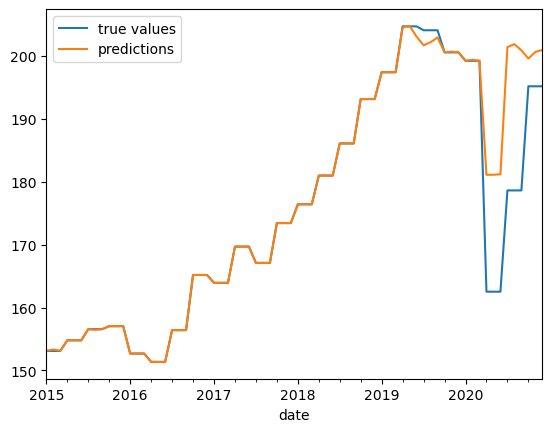

In [281]:
# plot of predictions vs test_values
pd.DataFrame({
    "true values":y_true, 
    "predictions":y_pred},
    index = all_dates).plot()

### Predict

In [305]:
prediction_date = data['date'].max() 

In [306]:
data_pred = data.drop(['date', target_variable], axis = 1)

In [307]:
# Pre-process test data
data_pred_processed = data_pred.fillna(method = 'ffill')
data_pred_processed = data_pred_processed.fillna(method = 'bfill')
#test_processed[continuous] = StandardScaler().fit_transform(test_processed[continuous])

In [308]:
data_pred_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cpi            97 non-null     float64
 1   energy_prices  97 non-null     float64
 2   metal_prices   97 non-null     float64
 3   agri_prices    97 non-null     float64
 4   confidence     97 non-null     float64
 5   gdp            97 non-null     float64
dtypes: float64(6)
memory usage: 5.3 KB


In [315]:
preds = []
for i in range(10):
    prediction = models[i].predict(data_pred_processed)[0]
    preds.append(prediction)
        
y = np.nanmean(preds)

In [363]:
d = {'Date': prediction_date, 'Exports':[y]}

In [364]:
result = pd.DataFrame(d)

In [366]:
result

,Date,Exports
0,2023-01-01,153.107619


In [370]:
result.to_csv('predict_exports', index=False)